# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [19]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2

In [20]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from keras import backend as K
tf.set_random_seed(30)

In [21]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [22]:
# Parameters initialization
x = 120   # X dimension of the image
y = 120   # Y dimesnion of the image
#total_frames = 30
z = 30  # lenght of the video frames
c = 3 # number rof channels in images 3 for color(RGB) and 1 for Gray

In [23]:
def normalize_image(img):
    #using percentile for normalization for images, as min-max is giving better results.
    # normalized_image= img - np.percentile(img,15)/ np.percentile(img,85) - np.percentile(img,15) 
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

In [24]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, 30,2)] 
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,z,x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print(imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    img_path = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    #print(img_path)
                    image = cv2.imread(img_path, cv2.IMREAD_COLOR)#.astype(np.float32)
                        
                    #print(image.shape)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # Cropping non symmetric frames
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,20:140]
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #resized = cv2.resize(image, (x,y), interpolation = cv2.INTER_AREA)
                    resized=imresize(image, (x,y))
                    batch_data[folder,idx,:,:,0] = normalize_image(resized[:, : , 0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(resized[:, : , 1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(resized[:, : , 2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,z,x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    #print(imgs)
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        img_path = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                        #print(img_path)
                        image = cv2.imread(img_path, cv2.IMREAD_COLOR)#.astype(np.float32)

                        #print(image.shape)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                        # Cropping non symmetric frames
                        if image.shape[0] != image.shape[1]:
                            image=image[0:120,20:140]
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        #resized = cv2.resize(image, (x,y), interpolation = cv2.INTER_AREA)
                        resized=imresize(image, (x,y))
                        batch_data[folder,idx,:,:,0] = normalize_image(resized[:, : , 0]) #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = normalize_image(resized[:, : , 1])#normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = normalize_image(resized[:, : , 2])#normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [25]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [26]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [27]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(z,x,y,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [28]:
from keras.optimizers import Adam
optimiser = Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 1s - loss: 1.8884 - categorical_accuracy: 0.2600

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 36s 543ms/step - loss: 1.8711 - categorical_accuracy: 0.2666 - val_loss: 1.4948 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2019-12-2308_39_36.409202/model-00001-1.87795-0.26244-1.49479-0.37000.h5
Epoch 2/10
67/67 [==============================] - 11s 171ms/step - loss: 1.6146 - categorical_accuracy: 0.1940 - val_loss: 1.5414 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2019-12-2308_39_36.409202/model-00002-1.61463-0.19403-1.54139-0.36000.h5
Epoch 3/10
67/67 [==============================] - 12s 175ms/step - loss: 1.5806 - categorical_accuracy: 0.2786 - val_loss: 1.5285 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model_init_2019-12-2308_39_36.409202/model-00003-1.58062-0.27861-1.52849-0.18000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
67/67 [==============================] - 12s 180ms/step - loss: 1.4790 - cat

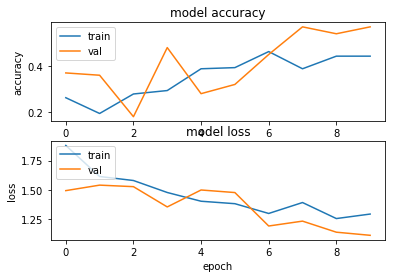

In [32]:
import matplotlib.pyplot as plt  
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print(history.history.keys())  
   
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 7s 202ms/step - loss: 1.2089 - categorical_accuracy: 0.4804 - val_loss: 1.1206 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2019-12-2308_39_36.409202/model-00001-1.20889-0.48039-1.12057-0.58000.h5
Epoch 2/20
34/34 [==============================] - 6s 173ms/step - loss: 1.1836 - categorical_accuracy: 0.5392 - val_loss: 1.0866 - val_categorical_accuracy: 0.7000

Epoch 00002: saving model to model_init_2019-12-2308_39_36.409202/model-00002-1.18356-0.53922-1.08663-0.70000.h5
Epoch 3/20
34/34 [==============================] - 6s 166ms/step - loss: 1.1249 - categorical_accuracy: 0.5098 - val_loss: 1.0946 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2019-12-2308_39_36.409202/model-00003-1.12488-0.50980-1.09461-0.58000.h5
Epoch 4/20
34/34 [==============================] - 5s 157ms/step - loss: 0.9788 - categorical_accuracy: 0.5392 - val_loss: 0.9770 - val_categorical_accuracy: 0.6600

Epoc

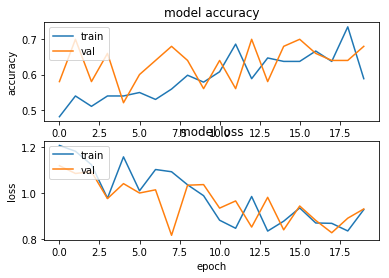

In [33]:
batch_size = 20
num_epochs = 20

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print(history.history.keys())  
   
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show() 

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 3s 211ms/step - loss: 0.8041 - categorical_accuracy: 0.6905 - val_loss: 1.0554 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2019-12-2308_39_36.409202/model-00001-0.80406-0.69048-1.05539-0.60000.h5
Epoch 2/30
14/14 [==============================] - 3s 198ms/step - loss: 0.9621 - categorical_accuracy: 0.5714 - val_loss: 0.9209 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2019-12-2308_39_36.409202/model-00002-0.96205-0.57143-0.92092-0.60000.h5
Epoch 3/30
14/14 [==============================] - 3s 198ms/step - loss: 1.0052 - categorical_accuracy: 0.5714 - val_loss: 0.9092 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2019-12-2308_39_36.409202/model-00003-1.00516-0.57143-0.90915-0.65000.h5
Epoch 4/30
14/14 [==============================] - 3s 179ms/step - loss: 0.9580 - categorical_accuracy: 0.5952 - val_loss: 0.7781 - val_categorical_accuracy: 0.7500

Epoc

14/14 [==============================] - 2s 158ms/step - loss: 0.7726 - categorical_accuracy: 0.6429 - val_loss: 0.8422 - val_categorical_accuracy: 0.7000

Epoch 00028: saving model to model_init_2019-12-2308_39_36.409202/model-00028-0.77261-0.64286-0.84222-0.70000.h5
Epoch 29/30
14/14 [==============================] - 2s 161ms/step - loss: 1.1580 - categorical_accuracy: 0.5238 - val_loss: 1.0395 - val_categorical_accuracy: 0.6500

Epoch 00029: saving model to model_init_2019-12-2308_39_36.409202/model-00029-1.15799-0.52381-1.03946-0.65000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.536743617033494e-10.
Epoch 30/30
14/14 [==============================] - 2s 176ms/step - loss: 1.2839 - categorical_accuracy: 0.4524 - val_loss: 0.7293 - val_categorical_accuracy: 0.8000

Epoch 00030: saving model to model_init_2019-12-2308_39_36.409202/model-00030-1.28391-0.45238-0.72934-0.80000.h5
dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr']

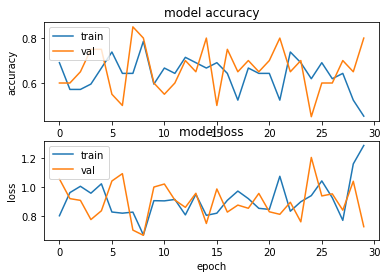

In [34]:
batch_size = 50
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print(history.history.keys())  
   
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show() 

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


8/8 [==============================] - 2s 246ms/step - loss: 0.8764 - categorical_accuracy: 0.6667 - val_loss: 0.9606 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2019-12-2308_39_36.409202/model-00001-0.87641-0.66667-0.96063-0.60000.h5
Epoch 2/30
8/8 [==============================] - 2s 189ms/step - loss: 0.8028 - categorical_accuracy: 0.6250 - val_loss: 0.7616 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2019-12-2308_39_36.409202/model-00002-0.80275-0.62500-0.76157-0.65000.h5
Epoch 3/30
8/8 [==============================] - 2s 189ms/step - loss: 0.8050 - categorical_accuracy: 0.7500 - val_loss: 0.8677 - val_categorical_accuracy: 0.7500

Epoch 00003: saving model to model_init_2019-12-2308_39_36.409202/model-00003-0.80504-0.75000-0.86774-0.75000.h5
Epoch 4/30
8/8 [==============================] - 2s 192ms/step - loss: 0.7763 - categorical_accuracy: 0.6250 - val_loss: 1.0205 - val_categorical_accuracy: 0.6000

Epoch 00004:


Epoch 00027: saving model to model_init_2019-12-2308_39_36.409202/model-00027-0.80329-0.75000-0.90396-0.70000.h5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 4.656613094254636e-13.
Epoch 28/30
8/8 [==============================] - 2s 193ms/step - loss: 1.0023 - categorical_accuracy: 0.5833 - val_loss: 0.8671 - val_categorical_accuracy: 0.6500

Epoch 00028: saving model to model_init_2019-12-2308_39_36.409202/model-00028-1.00230-0.58333-0.86710-0.65000.h5
Epoch 29/30
8/8 [==============================] - 1s 177ms/step - loss: 0.9414 - categorical_accuracy: 0.6250 - val_loss: 0.6962 - val_categorical_accuracy: 0.7500

Epoch 00029: saving model to model_init_2019-12-2308_39_36.409202/model-00029-0.94137-0.62500-0.69617-0.75000.h5
Epoch 30/30
8/8 [==============================] - 2s 207ms/step - loss: 1.0033 - categorical_accuracy: 0.4583 - val_loss: 1.0280 - val_categorical_accuracy: 0.6000

Epoch 00030: saving model to model_init_2019-12-2308_39_36.409202/model-00030-1.0

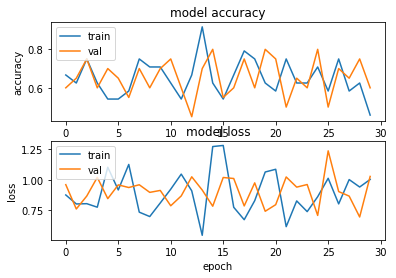

In [35]:
batch_size = 90
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print(history.history.keys())  
   
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show() 

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


5/5 [==============================] - 1s 261ms/step - loss: 0.7990 - categorical_accuracy: 0.6667 - val_loss: 0.7593 - val_categorical_accuracy: 0.8000

Epoch 00001: saving model to model_init_2019-12-2308_39_36.409202/model-00001-0.79898-0.66667-0.75933-0.80000.h5
Epoch 2/30
5/5 [==============================] - 1s 209ms/step - loss: 0.6744 - categorical_accuracy: 0.8667 - val_loss: 0.6995 - val_categorical_accuracy: 0.8000

Epoch 00002: saving model to model_init_2019-12-2308_39_36.409202/model-00002-0.67440-0.86667-0.69955-0.80000.h5
Epoch 3/30
5/5 [==============================] - 1s 169ms/step - loss: 0.8683 - categorical_accuracy: 0.7333 - val_loss: 0.8454 - val_categorical_accuracy: 0.7000

Epoch 00003: saving model to model_init_2019-12-2308_39_36.409202/model-00003-0.86833-0.73333-0.84540-0.70000.h5
Epoch 4/30
5/5 [==============================] - 1s 178ms/step - loss: 0.8868 - categorical_accuracy: 0.6000 - val_loss: 0.6290 - val_categorical_accuracy: 1.0000

Epoch 00004:


Epoch 00027: saving model to model_init_2019-12-2308_39_36.409202/model-00027-0.73173-0.66667-0.78939-0.80000.h5
Epoch 28/30
5/5 [==============================] - 1s 140ms/step - loss: 0.6444 - categorical_accuracy: 0.8000 - val_loss: 0.9236 - val_categorical_accuracy: 0.7000

Epoch 00028: saving model to model_init_2019-12-2308_39_36.409202/model-00028-0.64444-0.80000-0.92363-0.70000.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 5.551115386789603e-20.
Epoch 29/30
5/5 [==============================] - 1s 200ms/step - loss: 0.8759 - categorical_accuracy: 0.7333 - val_loss: 1.1283 - val_categorical_accuracy: 0.3000

Epoch 00029: saving model to model_init_2019-12-2308_39_36.409202/model-00029-0.87591-0.73333-1.12834-0.30000.h5
Epoch 30/30
5/5 [==============================] - 1s 190ms/step - loss: 0.8949 - categorical_accuracy: 0.5333 - val_loss: 0.9952 - val_categorical_accuracy: 0.6000

Epoch 00030: saving model to model_init_2019-12-2308_39_36.409202/model-00030-0.8

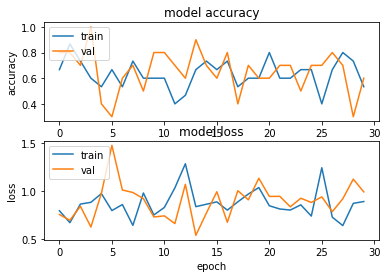

In [38]:
batch_size = 150
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print(history.history.keys())  
   
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show() 

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


4/4 [==============================] - 1s 271ms/step - loss: 0.7887 - categorical_accuracy: 0.5000 - val_loss: 0.8215 - val_categorical_accuracy: 0.8000

Epoch 00001: saving model to model_init_2019-12-2308_39_36.409202/model-00001-0.78873-0.50000-0.82146-0.80000.h5
Epoch 2/20
4/4 [==============================] - 1s 170ms/step - loss: 1.2022 - categorical_accuracy: 0.5000 - val_loss: 0.8343 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2019-12-2308_39_36.409202/model-00002-1.20224-0.50000-0.83429-0.60000.h5
Epoch 3/20
4/4 [==============================] - 1s 157ms/step - loss: 1.3509 - categorical_accuracy: 0.5000 - val_loss: 0.7176 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2019-12-2308_39_36.409202/model-00003-1.35088-0.50000-0.71756-0.60000.h5
Epoch 4/20
4/4 [==============================] - 1s 169ms/step - loss: 0.5044 - categorical_accuracy: 0.8333 - val_loss: 0.9564 - val_categorical_accuracy: 0.7000

Epoch 00004:

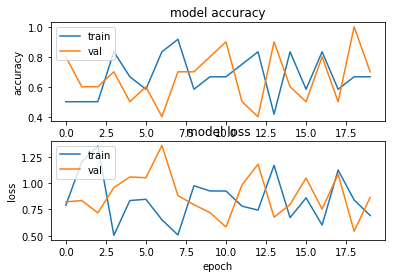

In [43]:
batch_size = 200
num_epochs = 20

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print(history.history.keys())  
   
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show() 

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


6/6 [==============================] - 1s 219ms/step - loss: 0.7440 - categorical_accuracy: 0.7778 - val_loss: 0.8387 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2019-12-2308_39_36.409202/model-00001-0.74403-0.77778-0.83867-0.60000.h5
Epoch 2/30
6/6 [==============================] - 1s 167ms/step - loss: 0.6366 - categorical_accuracy: 0.8889 - val_loss: 1.1046 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2019-12-2308_39_36.409202/model-00002-0.63661-0.88889-1.10464-0.60000.h5
Epoch 3/30
6/6 [==============================] - 1s 169ms/step - loss: 1.2524 - categorical_accuracy: 0.5000 - val_loss: 0.6920 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to model_init_2019-12-2308_39_36.409202/model-00003-1.25242-0.50000-0.69201-0.80000.h5
Epoch 4/30
6/6 [==============================] - 1s 154ms/step - loss: 1.0429 - categorical_accuracy: 0.5556 - val_loss: 1.1694 - val_categorical_accuracy: 0.6000

Epoch 00004:


Epoch 00030: saving model to model_init_2019-12-2308_39_36.409202/model-00030-1.29618-0.50000-0.78614-0.90000.h5
dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


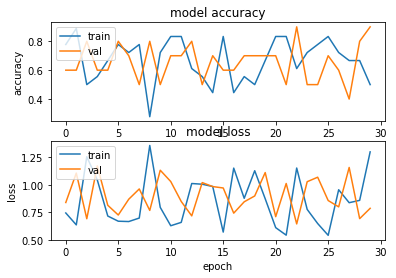

In [51]:
batch_size = 128
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print(history.history.keys())  
   
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show() 